# Mega_df_playground


## Basic Set Up

#### Load Modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from IPython.display import display
import seaborn as sn
from pandas import DataFrame
import requests
import gmaps
import os
from pprint import pprint
import re 

# Import API key
from api_keys import g_key
from api_keys import weather_key

#### Create path to read files

In [2]:
# Files to Load 
continent_file = "Resources/continent_code.csv"
climate_file = "Resources/country_climate.csv"
export_file = "Resources/country_export.csv"
industry_file = "Resources/country_industry.csv"
consumption_file = "Resources/country_consumption.csv"
happiness_file = "Resources/country_happiness.csv"
mental_health_file = "Resources/mental_health.csv"
capitals_file = "Resources/country_capitals.csv"

# Read csv and store into Pandas DataFrames
continent_data = pd.read_csv(continent_file)
climate_data = pd.read_csv(climate_file)
export_data = pd.read_csv(export_file)
industry_data = pd.read_csv(industry_file)
consumption_data = pd.read_csv(consumption_file)
happiness_data = pd.read_csv(happiness_file)
mental_health_data = pd.read_csv(mental_health_file)
capitals_data = pd.read_csv(capitals_file)

## Clean Dataframes 

In [3]:
# Clean Dataframes before merge - continent_df
continent_df = continent_data[["Continent_Name","Three_Letter_Country_Code"]] 
continent_df = continent_df.rename(columns={"Three_Letter_Country_Code": "country_code", "Continent_Name": "continent" })

# Clean Dataframes before merge - climate_df
climate_df = climate_data[["COUNTRY","CLIMATE"]]
climate_df  = climate_df.rename(columns={"COUNTRY": "country", "CLIMATE": "climate" })

# Clean Dataframes before merge - consumption_df 
consumption_df  = consumption_data.rename(columns={"Entity": "country", "Code": "country_code", 
                                                   "Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)": "consumption_per_capita_(L)"})

# Clean Dataframes before merge - happiness_df 
happiness_df = happiness_data[["Country name", "Regional indicator", "Ladder score", "Healthy life expectancy","Logged GDP per capita"]]
happiness_df = happiness_df.rename(columns= {"Country name": "country", "Regional indicator": "region", "Ladder score": "happy_score", "Healthy life expectancy": "life_expectancy", "Logged GDP per capita" : "gdp_per_capita"})
 

In [4]:
# Clean Dataframes before merge - wellness_df
wellness_df = mental_health_data.rename(columns={"Entity":"country", "Code": "code", "Year": "year", 
                                                 "Prevalence - Mental and substance use disorders - Sex: Both - Age: Age-standardized (Percent)": "mental_health_and_addiction (%)"})
to_drop = ["Andean Latin America", "Australasia", "Caribbean", "Central Asia", "Central Europe", "Central Europe, Eastern Europe, and Central Asia",
            "Central Latin America", "Central Sub-Saharan Africa", "East Asia", "Eastern Europe", "Eastern Sub-Saharan Africa",
            "England", "High SDI", "High Income", "High-income Asia Pacific", "High-middle SDI", "Latin America and Caribbean",
            "Low SDI", "Low-middle SDI", "Middle SDI", "North Africa and Middle East", "North America", "Northern Ireland", "Oceania",
            "Scotland", "South Asia", "Southeast Asia", "Southeast Asia, East Asia, and Oceania", "Southern Latin America", 
            "Southern Sub-Saharan Africa", "Sub-Saharan Africa", "Tropical Latin America", "Wales", "Western Europe", "Western Sub-Saharan Africa",
            "World"] 
wellness_df = wellness_df[~wellness_df['country'].isin(to_drop)]
wellness_df = wellness_df[wellness_df['code'].notna()]

# Create a new dataframe to show the avg percentage of mental health and addiction observed for each country
wellness_subset = wellness_df.groupby(['code'])
average_wellness_df = wellness_subset.mean()
country_mask = wellness_df.groupby("country")
wellness_df = country_mask.first() 

wellness_df = wellness_df.drop(columns=['year'])
#wellness_df

In [5]:
# Clean Dataframes before merge - capitals_df
capitals_data.shape[0] 


248

## Merge DataFrames
* df_2 = continent_df + consumption_df
* df_3 = continent_df + consumption_df + climate_df
* df_4 = continent_df + consumption_df + climate_df + export_data
* df_5 = continent_df + consumption_df + climate_df + export_data + industry_data
* df_6 = continent_df + consumption_df + climate_df + export_data + industry_data + happiness_df
* df_7 = continent_df + consumption_df + climate_df + export_data + industry_data + happiness_df + wellness_df

In [6]:
# Combine the data into a single dataset.  
df_2 = pd.merge(continent_df, consumption_df, how="outer", on=["country_code", "country_code"])  
df_3 = pd.merge(df_2, climate_df, how="outer", on=["country", "country"]) 
df_4 = pd.merge(df_3, export_data, how="outer", on=["country", "country"]) 
df_5 = pd.merge(df_4, industry_data, how="outer", on=["country", "country"]) 
df_6 = pd.merge(df_5, happiness_df, how="outer", on=["country", "country"]) 
df_7 = pd.merge(df_6, wellness_df, how="outer", on=["country", "country"]) 
df_8 = pd.merge(df_7, capitals_data, how="outer",on=["country", "country"])

# Remove all rows where continent == 'Antartica'
to_drop = ['Antarctica']
df_9 = df_8[~df_8['continent'].isin(to_drop)]
df_9.count() 

# Remove all rows where there is no value for alcohol consumption 
df_10 = df_9[df_9['consumption_per_capita_(L)'].notna()] 
df_10.count() 


# Remove all non-countries within 'country' column
to_drop = ['Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend',
          'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)',
          'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)',
          'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income',
          'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (IDA & IBRD)', 'Latin America & Caribbean (excluding high income)',
          'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income','Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD)','Middle East & North Africa (excluding high income)',
          'Middle income', 'North America', 'OECD members', 'Other small states', 'Pacific island small states',
          'Post-demographic dividend', 'Pre-demographic dividend','Small states', 'South Asia', 'South Asia (IDA & IBRD)',
          'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD)', 'Sub-Saharan Africa (excluding high income)',
          'Syrian Arab Republic', 'Upper middle income', 'World']
df_11 = df_10[~df_10['country'].isin(to_drop)]
df_11.count() 

# Remove all duplicate countries --> Azerbaijan, Armenia, Cypress, Georgia, Kazakstan, Turkey
df_12 = df_11.drop_duplicates(subset=['country'])

df_12 = df_12.reset_index() 

df_12.head() 



,index,continent,country_code,country,consumption_per_capita_(L),climate,main_export,main_industry,region,happy_score,life_expectancy,gdp_per_capita,code,mental_health_and_addiction (%),capital
0,0,Asia,AFG,Afghanistan,0.2,arid to semiarid; cold winters and hot summers,Fruit and nuts,small-scale production of bricks,South Asia,2.5669,52.590000,7.462861,AFG,17.553463,Kabul
1,1,Europe,ALB,Albania,7.5,"mild temperate; cool, cloudy, wet winters; hot...",Chromium and chrome products,perfumes and cosmetic products,Central and Eastern Europe,4.8827,68.708138,9.417931,ALB,10.987610,Tirana
2,4942,Africa,DZA,Algeria,0.9,"arid to semiarid; mild, wet winters with hot, ...",Oil,petroleum,Middle East and North Africa,5.0051,65.905174,9.537965,DZA,14.700388,Algiers
3,4943,Europe,AND,Andorra,11.3,"temperate; snowy, cold winters and warm, dry s...",Tobacco products,tourism,NaN,NaN,NaN,NaN,AND,14.726869,Andorra la Vella
4,4944,Africa,AGO,Angola,6.4,semiarid in south and along coast to Luanda; n...,Oil,petroleum,NaN,NaN,NaN,NaN,AGO,12.498281,Luanda


In [7]:
# Save Data to csv
df_12.to_csv("mega_df.csv")

## Data Summary
* Display a list of columns in the dataset
* Display a list of regions in the dataset
* Display a list of countries in the dataset
* Calculate total number of countries
* Calculate overall average alcohol consumption
* Calculate total years of data compiled for each country 
* Determine which year(s) have the most data 


####  Display a list of columns

In [7]:
columns = df_12.columns
columns_string =', '.join(columns)
print(f"List of column names: {columns_string}")

List of column names: index, continent, country_code, country, consumption_per_capita_(L), climate, main_export, main_industry, region, happy_score, life_expectancy, gdp_per_capita, code, mental_health_and_addiction (%), capital


#### Display a list of regions

In [8]:
regions = df_12["region"].unique()
regions_string = ", ".join(map(str, regions))

print(f"List of regions represented in the dataset: {regions_string}")
regions

DataFrame.dropna

List of regions represented in the dataset: South Asia, Central and Eastern Europe, Middle East and North Africa, nan, Commonwealth of Independent States, Latin America and Caribbean, North America and ANZ, Western Europe, Sub-Saharan Africa, Southeast Asia, East Asia


<function pandas.core.frame.DataFrame.dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False)>

#### Display a list of countries

In [9]:
countries = df_12["country"].unique()
countries_string = ', '.join(countries)

print(f"List of countries represented in the dataset: {countries_string}")

List of countries represented in the dataset: Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Azerbaijan, Argentina, Australia, Austria, Bahamas, Bahrain, Bangladesh, Armenia, Barbados, Belgium, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Belize, Solomon Islands, Brunei, Bulgaria, Myanmar, Burundi, Belarus, Cambodia, Cameroon, Canada, Cape Verde, Central African Republic, Sri Lanka, Chad, Chile, China, Colombia, Comoros, Congo, Democratic Republic of Congo, Costa Rica, Croatia, Cuba, Cyprus, Czechia, Benin, Denmark, Dominica, Dominican Republic, Ecuador, El Salvador, Equatorial Guinea, Ethiopia, Eritrea, Estonia, Fiji, Finland, France, Djibouti, Gabon, Georgia, Gambia, Germany, Ghana, Kiribati, Greece, Grenada, Guatemala, Guinea, Guyana, Haiti, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Cote d'Ivoire, Jamaica, Japan, Kazakhstan, Jordan, Kenya, North Korea, South Korea, Kuwait, Kyrgyzstan, Laos, Lebanon, Lesotho,

####  Calculate how many countries are represented in the data 

In [10]:
total_countries = df_12.shape[0] 
print(f'The total number of rows countries represented in the dataset are {total_countries}.') 

# Alternative methods:
#number_countries = df_11['country'].nunique()
# unique_countries = df_8['country'].unique()
# number_countries = len(unique_countries)

The total number of rows countries represented in the dataset are 186.


#### Calculate the overall average alcohol consumption


In [11]:
overall_avg_consumption = df_12["consumption_per_capita_(L)"].mean() 
overall_avg_consumption
formatted_consumption = round(overall_avg_consumption,2)

print(f"The overall average of alcohol consumption per capita (liters) among countries represented in the dataset is {overall_avg_consumption}.")  


The overall average of alcohol consumption per capita (liters) among countries represented in the dataset is 6.165053763440862.


#### Find the 10 countries that consumes the most alcohol 


In [12]:
country_mask = df_12.groupby("country")
country_subset = country_mask.first()


high_consumption = country_subset.sort_values([("consumption_per_capita_(L)")], ascending=False).head(n=10)
high_consumption.reset_index() 

high_consumption_series = high_consumption["consumption_per_capita_(L)"], high_consumption["capital"] 

high_consumption_df = pd.DataFrame(high_consumption_series)
high_consumption_df = high_consumption_df.transpose()

most_alcohol = high_consumption_df.index.tolist()

print("The countries with the highest consumption rates are " + ", ".join(most_alcohol))

capitals = high_consumption_df['capital'].tolist()  

capitals 

The countries with the highest consumption rates are Moldova, Lithuania, Czechia, Nigeria, Germany, Luxembourg, Ireland, Latvia, Bulgaria, Slovenia


['Chisinau',
 'Vilnius',
 nan,
 'Abuja',
 'Berlin',
 'Luxembourg',
 'Dublin',
 'Riga',
 'Sofia',
 'Ljubljana']

#### Find latitude and longitude for the 10 countries with the highest consumption

In [13]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_key}&units={units}&q="

In [14]:
# Convert capital column to list
capitals = high_consumption_df['capital'].tolist()  

# Create container for list of capitals
cities = ['Chisinau','Vilnius','Prague','Abuja','Berlin','Luxembourg','Dublin','Riga','Sofia','Ljubljana']

# Set up lists to hold reponse info
lat = []
lon = []

# Loop through the list of cities and perform a request for data on each
for city in cities:
    response = requests.get(query_url + city).json()
    lat.append(response['coord']['lat'])
    lon.append(response['coord']['lon'])

print(f"The latitude information received is: {lat}")
print(f"The longitude information received is: {lon}") 

The latitude information received is: [47.0056, 54.6892, 50.088, 9.0574, 52.5244, 50, 37.7021, 57, 42.6975, 46.0511]
The longitude information received is: [28.8575, 25.2798, 14.4208, 7.4898, 13.4105, 5.5, -121.9358, 24.0833, 23.3242, 14.5051]


#### Add latitude and longitude columns to dataframe

In [15]:
high_consumption_df['latitude'] = lat
high_consumption_df['longitude'] = lon

high_consumption_df

,consumption_per_capita_(L),capital,latitude,longitude
country,,,,
Moldova,15.2,Chisinau,47.0056,28.8575
Lithuania,15,Vilnius,54.6892,25.2798
Czechia,14.4,NaN,50.0880,14.4208
Nigeria,13.4,Abuja,9.0574,7.4898
Germany,13.4,Berlin,52.5244,13.4105
Luxembourg,13,Luxembourg,50.0000,5.5000
Ireland,13,Dublin,37.7021,-121.9358
Latvia,12.9,Riga,57.0000,24.0833
Bulgaria,12.7,Sofia,42.6975,23.3242


#### Create a heatmap to display the drunkest countries



In [16]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)


In [33]:
# Store 'Lat' and 'Lng' into  locations 
locations = high_consumption_df[["latitude", "longitude"]]

# Create a poverty Heatmap layer
fig = gmaps.figure(center=[10,15], zoom_level=2)

heat_layer = gmaps.heatmap_layer(locations, weights=high_consumption_df['consumption_per_capita_(L)'], dissipating=False, max_intensity=15, point_radius = 4)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

#### Find the 10 countries that consumes the least alcohol 

In [34]:
low_consumption = country_subset.sort_values([("consumption_per_capita_(L)")], ascending=True).head(n=10)
low_consumption.reset_index() 

low_consumption_series = low_consumption["consumption_per_capita_(L)"]  
low_consumption_df = pd.DataFrame(low_consumption_series)

least_alcohol = low_consumption_df.index.tolist()

print("The countries with the lowest consumption rates are " + ", ".join(least_alcohol))

low_consumption_df

The countries with the lowest consumption rates are Somalia, Mauritania, Libya, Bangladesh, Kuwait, Yemen, Afghanistan, Saudi Arabia, Pakistan, Iraq


,consumption_per_capita_(L)
country,
Somalia,0.0
Mauritania,0.0
Libya,0.0
Bangladesh,0.0
Kuwait,0.0
Yemen,0.1
Afghanistan,0.2
Saudi Arabia,0.2
Pakistan,0.3


## Data Summary


In [35]:
print(f"List of column names: {columns_string}")
print("------------------------------------------------------------------------------------------")
print(f"List of regions represented in the dataset: {regions_string}")
print("------------------------------------------------------------------------------------------")
print(f"List of countries represented in the dataset: {countries_string}")
print("------------------------------------------------------------------------------------------")
print(f"Total number of countries represented in the dataset: {total_countries}")
print("------------------------------------------------------------------------------------------")
print(f"Overall average of alcohol consumption per capita (liters): {formatted_consumption}") 
print("------------------------------------------------------------------------------------------")
print("The 10 countries with the highest consumption rates of alcohol: " + ", ".join(most_alcohol))
print("------------------------------------------------------------------------------------------")
print("The 10 countries with the lowest consumption rates of alchohol: " + ", ".join(least_alcohol)) 



List of column names: index, continent, country_code, country, consumption_per_capita_(L), climate, main_export, main_industry, region, happy_score, life_expectancy, gdp_per_capita, code, mental_health_and_addiction (%), capital
------------------------------------------------------------------------------------------
List of regions represented in the dataset: South Asia, Central and Eastern Europe, Middle East and North Africa, nan, Commonwealth of Independent States, Latin America and Caribbean, North America and ANZ, Western Europe, Sub-Saharan Africa, Southeast Asia, East Asia
------------------------------------------------------------------------------------------
List of countries represented in the dataset: Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Azerbaijan, Argentina, Australia, Austria, Bahamas, Bahrain, Bangladesh, Armenia, Barbados, Belgium, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Belize, Solomon Islands, Brunei, Bulgaria, My

## Part Three  - Consumption & Geography -  Continent 

#### Use a for loop to find consumption averages by continent

In [45]:
# Create containers to hold aggregate values for each continent in for loop
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania'] 
segment_values = []
number_countries = []

# Filter each segment from our list 'continent' in the dataframe
for continent in continents:
    df = country_subset.loc[country_subset["continent"] == continent]
    # Aggregate the consumption values for each continent in the dataframe
    values = df['consumption_per_capita_(L)'].sum()
    segment_values.append(values)
    # Find number of countries for each continent in the dataframe
    consumption_by_segment = len(df)
    number_countries.append(consumption_by_segment)
    # Find the average consumption for each continent
    # Division is not a supported operation on lists so use np.array to perform a function
    avg_consumption_by_continent = np.array([segment_values]) / np.array([number_countries])
    
    
#print(avg_consumption_by_continent[0][0])
#print(segment_values)
#print(number_countries) 

df = pd.DataFrame({"continent": continents, "total_consumption(liters)": segment_values, "avg_consumption(liters)": avg_consumption_by_continent [0], "num_countries": number_countries})
df = df.sort_values("avg_consumption(liters)", ascending=False)
df

,continent,total_consumption(liters),avg_consumption(liters),num_countries
2,Europe,473.4,10.291304,46
4,South America,83.2,6.933333,12
3,North America,157.3,6.839130,23
0,Africa,252.7,4.767925,53
5,Oceania,42.5,3.541667,12
1,Asia,137.6,3.440000,40


### Create a boxplot to compare consumption values for each continent 

<AxesSubplot:title={'center':'consumption_per_capita_(L)'}, xlabel='continent'>

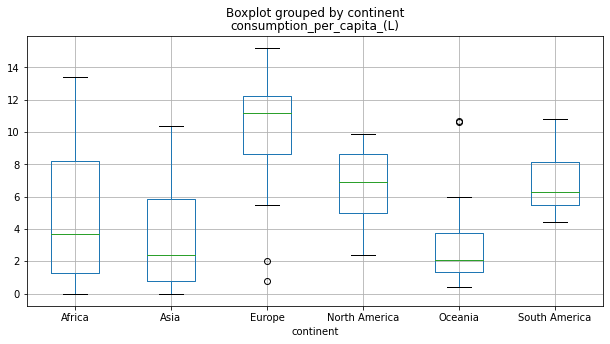

In [46]:
# Create lists for every country
#type(df_12)

df_12.boxplot("consumption_per_capita_(L)",by="continent", figsize=(10,5)) 

In [53]:
# Step 5: Create containers and conditionals for for loop
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
values = []

# Step 6: Locate each drug from our list 'drugs' in the orginal dataframe
for continent in continents:
    df = country_subset.loc[country_subset["continent"] == continent]
    
    # Create a series that consists of all final volume values for each regimen
    values = df['consumption_per_capita_(L)']
    
    # Calculate and print the interquartile range (IQR) for each regimen
    quartiles = values.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f'IQR for {continent}: {iqr}')
    
    # Find upper and lower bounds to help identify outliers for each regimen
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f'Lower Bound for {continent}: {lower_bound}')
    print(f'Upper Bound for {continent}: {upper_bound}')
    
    # Quantitatively check for outliers
    outliers_count = (values.loc[(df['consumption_per_capita_(L)'] >= upper_bound) | 
                                        (df['consumption_per_capita_(L)'] <= lower_bound)]).count()
    print(f'Number of {continent} outliers: {outliers_count}')

IQR for Africa: 6.8999999999999995
Lower Bound for Africa: -9.049999999999999
Upper Bound for Africa: 18.549999999999997
Number of Africa outliers: 0
IQR for Asia: 5.05
Lower Bound for Asia: -6.799999999999999
Upper Bound for Asia: 13.399999999999999
Number of Asia outliers: 0
IQR for Europe: 3.6250000000000018
Lower Bound for Europe: 3.1874999999999973
Upper Bound for Europe: 17.687500000000004
Number of Europe outliers: 2
IQR for North America: 3.6500000000000004
Lower Bound for North America: -0.47500000000000053
Upper Bound for North America: 14.125
Number of North America outliers: 0
IQR for South America: 2.700000000000001
Lower Bound for South America: 1.424999999999998
Upper Bound for South America: 12.225000000000001
Number of South America outliers: 0
IQR for Oceania: 2.4000000000000004
Lower Bound for Oceania: -2.250000000000001
Upper Bound for Oceania: 7.3500000000000005
Number of Oceania outliers: 2


In [60]:
# Identify the outliers in the Oceania subset data
oceania_df = country_subset.loc[country_subset['continent'] == 'Oceania']
outliers_oceania = oceania_df.loc[(oceania_df['consumption_per_capita_(L)'] >= 7.3500000000000005) | 
                                        (oceania_df['consumption_per_capita_(L)'] <= -2.250000000000001)] 
outliers_oceania



,index,continent,country_code,consumption_per_capita_(L),climate,main_export,main_industry,region,happy_score,life_expectancy,gdp_per_capita,code,mental_health_and_addiction (%),capital
country,,,,,,,,,,,,,,
Australia,4949,Oceania,AUS,10.6,generally arid to semiarid; temperate in south...,Ores and metals,mining,North America and ANZ,7.2228,73.604538,10.720596,AUS,18.077892,Canberra
New Zealand,5066,Oceania,NZL,10.7,temperate with sharp regional contrasts,Wool,food processing,North America and ANZ,7.2996,73.202629,10.500943,NZL,18.495605,Wellington


In [61]:
# Identify the outliers in the Europe subset data
europe_df = country_subset.loc[country_subset['continent'] == 'Europe']
outliers_europe = europe_df.loc[(europe_df['consumption_per_capita_(L)'] >= 17.687500000000004) | 
                                        (europe_df['consumption_per_capita_(L)'] <= 3.1874999999999973)] 
outliers_europe

,index,continent,country_code,consumption_per_capita_(L),climate,main_export,main_industry,region,happy_score,life_expectancy,gdp_per_capita,code,mental_health_and_addiction (%),capital
country,,,,,,,,,,,,,,
Azerbaijan,4946,Europe,AZE,0.8,"dry, semiarid steppe",Oil,petroleum and natural gas,Commonwealth of Independent States,5.1648,65.508400,9.687727,AZE,10.495815,Baku
Turkey,5116,Europe,TUR,2.0,"temperate; hot, dry summers with mild, wet win...",Clothing and textiles,textiles,Middle East and North Africa,5.1318,66.902817,10.129419,TUR,14.536026,Ankara


#### Consumption by Continent - Asia

In [62]:
# Consumption - Asia
asia_df = country_subset.loc[country_subset["continent"] == "Asia"]
asia_consumption = asia_df['consumption_per_capita_(L)'].sum()
countries_in_asia = len(asia_df)

avg_consumption_asia = asia_consumption / countries_in_asia
avg_consumption_asia 

3.4400000000000004

#### Consumption by Continent - Oceania

In [63]:
# Consumption - Oceania
oceania_df = country_subset.loc[country_subset["continent"] == "Oceania"]
oceania_consumption = asia_df['consumption_per_capita_(L)'].sum()
countries_in_oceania = len(oceania_df)

avg_consumption_oceania = oceania_consumption / countries_in_oceania

#### Consumption by Continent - Africa

In [64]:
# Consumption - Africa
africa_df = country_subset.loc[country_subset["continent"] == "Africa"]
africa_consumption = africa_df['consumption_per_capita_(L)'].sum()
countries_in_africa = len(africa_df)

avg_consumption_africa = africa_consumption / countries_in_africa

#### Consumption by Continent - North America

In [65]:
# Consumption - North America
north_america_df = country_subset.loc[country_subset["continent"] == "North America"]
north_america_consumption = north_america_df['consumption_per_capita_(L)'].sum()
countries_in_north_america = len(north_america_df)

avg_consumption_north_america = north_america_consumption / countries_in_north_america

#### Consumption by Continent - Europe

In [66]:
# Consumption - Europe
europe_df = country_subset.loc[country_subset["continent"] == "Europe"]
europe_consumption = europe_df['consumption_per_capita_(L)'].sum()
countries_in_europe = len(europe_df)

avg_consumption_europe = europe_consumption / countries_in_europe

#### Consumption by Continent - South America

In [67]:
# Consumption - South America
south_america_df = country_subset.loc[country_subset["continent"] == "South America"]
south_america_consumption = south_america_df['consumption_per_capita_(L)'].sum()
countries_in_south_america = len(south_america_df)

avg_consumption_south_america = south_america_consumption / countries_in_south_america

#### Consumption by Continent -  Summary

In [68]:
print(avg_consumption_asia)
print(avg_consumption_oceania)
print(avg_consumption_africa)
print(avg_consumption_north_america)
print(avg_consumption_europe)
print(avg_consumption_south_america)

3.4400000000000004
11.466666666666669
4.767924528301887
6.839130434782609
10.291304347826086
6.933333333333333


#### Consumption by Continent - Bar Graph 

Text(0, 0.5, 'Average Alcohol Consumption Per Capita (Liters)')

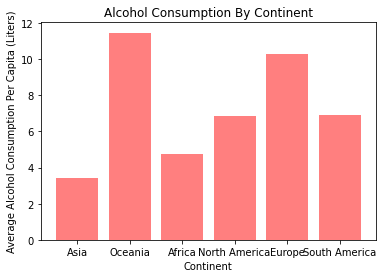

In [69]:
# Define x and y axis
y = [avg_consumption_asia, avg_consumption_oceania, avg_consumption_africa, avg_consumption_north_america, avg_consumption_europe, avg_consumption_south_america ]
x = np.arange(len(y)) 

# Plot bar graph
plt.bar(x, y, color='r', alpha=0.5, align="center")

# Add Labels
tick_locations = [value for value in x]
plt.xticks(tick_locations, ["Asia", "Oceania", "Africa", "North America", "Europe", "South America"])
plt.title("Alcohol Consumption By Continent")
plt.xlabel("Continent")
plt.ylabel("Average Alcohol Consumption Per Capita (Liters)")

###  Part Three  - Consumption & Geography - Region 

#### Use a for loop to find consumption averages by region

In [ ]:
country_subset["region"].value_counts()

In [ ]:
# Create containers to hold aggregate values for each continent in for loop
region = ['Sub-Saharan Africa ', 'Latin America and Caribbean', 'Western Europe', 'Middle East and North Africa',
          'Central and Eastern Europe', 'Commonwealth of Independent States', 'Southeast Asia',
          'North America and ANZ','East Asia'] 
segment_values = []
number_countries = []

# Filter each segment from our list 'continent' in the dataframe
for continent in continent:
    df = country_subset.loc[country_subset["continent"] == continent]
    # Aggregate the consumption values for each continent in the dataframe
    values = df['consumption_per_capita_(L)'].sum()
    segment_values.append(values)
    # Find number of countries for each continent in the dataframe
    consumption_by_segment = len(df)
    number_countries.append(consumption_by_segment)
    # Find the average consumption for each continent
    # Division is not a supported operation on lists so use np.array to perform a function
    avg_consumption_by_region = np.array([segment_values]) / np.array([number_countries])
    
print(avg_consumption_by_region)
print(segment_values)
print(number_countries) 

In [ ]:
df_12.boxplot("consumption_per_capita_(L)", by="region", figsize=(20, 10))

In [ ]:
# Merge all exports related to oil and petroleum
df_11['main_export'] = df_11['main_export'].replace({"Crude oil": "Oil"}) 
df_11['main_export'] = df_11.loc['main_export'].replace({"Petroleum": "Oil"}) 
# df_11['main_export'] = df_11.loc['main_export'].replace({"Crude oil and petroleum products": "Oil"}) 
# df_11['main_export'] = df_11.loc['main_export'].replace({"Oil and gas": "Oil"}) 
# df_11['main_export'] = df_11.loc['main_export'].replace({"Fuels and fuel products": "Oil"}) 
# df_11['main_export'] = df_11.loc['main_export'].replace({"Petroleum and petroleum products": "Oil"}) 

# # Merge all exports related to electronics
# df_11['main_export'] = df_11.loc['main_export'].replace({"Electronic equipment": "Electronic products"}) 
  
#.loc[row_index,col_indexer]

In [ ]:
df_11

###  Part Four  - Economy - Industry


In [ ]:
df_8.columns

### Part Five - Correlation & Regression

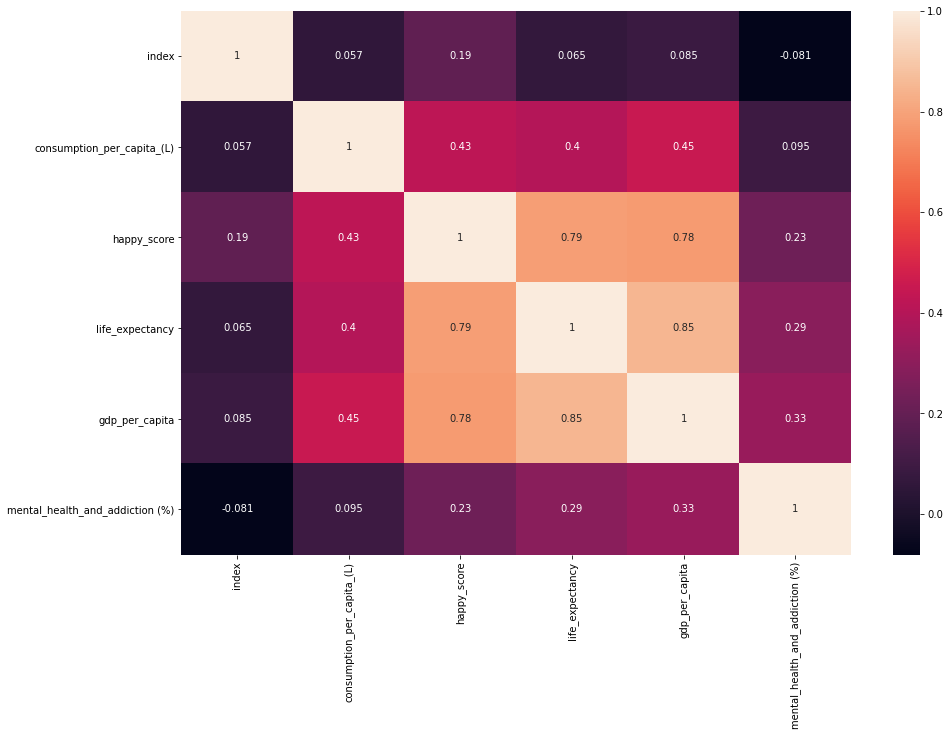

In [8]:
# Explore potential relationships by creating correlation matrix
from matplotlib.pyplot import figure

df_12_corr = df_12.corr()
df_12_corr.unstack().sort_values()

plt.rcParams['figure.figsize'] = (15.0, 10.0)
figure = (sn.heatmap(df_12_corr, annot=True,))

